# Python interface 

## Step 0: creating the **spinfoam** shared library

Let's start importing the *spinfoam.py* module 

In [1]:
import spinfoam as sf

We clean all the previous executable and object files, along with the corresponding folders

In [2]:
sf.spinfoam_clean()

rm -rf obj
rm -rf lib
rm -rf bin


If all dependencies are satisifed, the following cell should compile and build all the required files.

Notice that you can also compile in debug mode with **spinfoam_compile_debug()**

In [3]:
sf.spinfoam_compile()

   CXX    obj/mcmc.o
   CXX    obj/hash_21j_symbols.o
   CXX    obj/python_mirror.o
   CXX    lib/libspinfoam.so
   CXX    bin/Metropolis_Hastings_parallel_run
   CXX    bin/Hashing_21j


## Part 1: calling C++ functions 

In this first part use the spinfoam shared library in order to call C++ code implemented in the `./src` folder.

### Step 2: Hashing tables of 21j Wigner symbols 

Now we compute the hash tables with 21j Wigner symbols, which will be retrieved during the next step.
These tables are, in fact, a key ingredient for the Metropolis-Hastings algorithm which we implement in step 3.

For the calculation, we use the _wigxjpf_ and _fastwigxj_ libraries [Johansson et al., 2015].
For ease of use, all the necessary hash tables of 3j, 6j and 9j Wigner symbols have been previously computed and stored in `./ext/fastwig_tables/`.

We use the [parallel hashmap](https://github.com/greg7mdp/parallel-hashmap) in order to store the 21j Wigner symbols hash tables. 

In [3]:
# this is the folder with the pre-computed hash tables of 3j, 6j and 9j Wigner symbols.
# Jupyter kernel dies if tables are not found (C function returns "EXIT FAILURE")
fastwig_tables_path = "./ext/fastwig_tables"

# this is the folder in which we decide to store the computed hash tables of 21j symbols
hash_tables_path = "./ext/hashed_21j"

# value of all boundary spins of the spinfoam
spin = 0.5

In [4]:
sf.Hashing_21j_symbols(hash_tables_path, fastwig_tables_path, spin)

Hashing all 21j symbols with j <= 0.5...
Completed! The hash table has been stored


### Step 3: Metropolis-Hastings run

We can now compute and assemble the Markov chains by running the MH algorithm. The computed draws are stored in the given folder.

We run in parallel an independent Markov chain for each provided thread.

Each thread retrieves from the 21j hash table (computed in step 2) the required symbol, according to the position in the spins configuration space

In [8]:
# this is the folder in which we decide to store the draws
draws_folder = "./data_folder/collected_draws"

# this is the folder with the pre-computed hash tables of 21j Wigner symbols (see Step 2).
# Jupyter kernel dies if tables are not found (C function returns "EXIT FAILURE")
hash_tables_path = "./ext/hashed_21j"

# MH parameters
spin = 1
length = 1000000
sigma = 0.4
burnin = 10
verbosity = 0

# set optimal number of threads
import multiprocessing

number_of_threads = int(multiprocessing.cpu_count())

In [6]:
number_of_threads

12

In [7]:
sf.Metropolis_Hastings_parallel_run(draws_folder, hash_tables_path, spin,
                                    length, sigma, burnin, verbosity,
                                    number_of_threads)


Starting 12 independent Markov chains...
Completed! All draws have been stored


## Part 2: Python  

In this second part we manipulate the csv files, computed and stored in the first part, with pure Python code

### Step 4: Computing expectation values of angles

We manipulate the computed csv files in order to extract the informations we are interested in.

So far, we implemented the computation of expectation values of boundary angles operator in the intertwiner basis.

In [101]:
draws_folder = "./data_folder/collected_draws"
angles_folder = "./public_final_data"
spin = 3
length = 1000000
sigma = 0.35
burnin = 10

In the cell below we process *in parallel* (with the **threading** module) the draws computed in C++ and stored in Step 3.

For each Markov chain there's a corresponding CSV file. 

For each csv file, we compute the average of all the angle operators over all the 16 intertwiners, and we store everything

In [7]:
sf.from_draw_to_angles_average_multithreading(draws_folder, spin, length,
                                              sigma, burnin, angles_folder, 3)


In [102]:
df = sf.retrieve_combined_angles(angles_folder, spin, length, sigma, burnin,
                                 30)


In [103]:
df

,angle average,accept. rate,run time
chain 14,-0.333657,35.0,21850.5
chain 24,-0.322947,35.0,21998.4
chain 4,-0.337497,34.0,22392.0
chain 18,-0.334506,35.0,22139.9
chain 30,-0.333170,35.0,22291.7
chain 2,-0.334412,35.0,22472.2
chain 19,-0.330427,35.0,22024.6
chain 25,-0.331572,35.0,22085.7
chain 11,-0.347395,35.0,21692.4
chain 23,-0.333072,35.0,21941.0


# Plots

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd
import numpy as np

# Setting plot style

sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

rc('text', usetex=True)

sns.set_style("ticks")
sns.set_style(
    "whitegrid", {
        'axes.edgecolor':
        'black',
        'axes.grid':
        True,
        'axes.axisbelow':
        True,
        'axes.labelcolor':
        '.15',
        'grid.color':
        '0.9',
        'grid.linestyle':
        '-',
        'xtick.direction':
        'in',
        'ytick.direction':
        'in',
        'xtick.bottom':
        True,
        'xtick.top':
        True,
        'ytick.left':
        True,
        'ytick.right':
        True,
        'font.family': ['sans-serif'],
        'font.sans-serif':
        ['Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],
    })


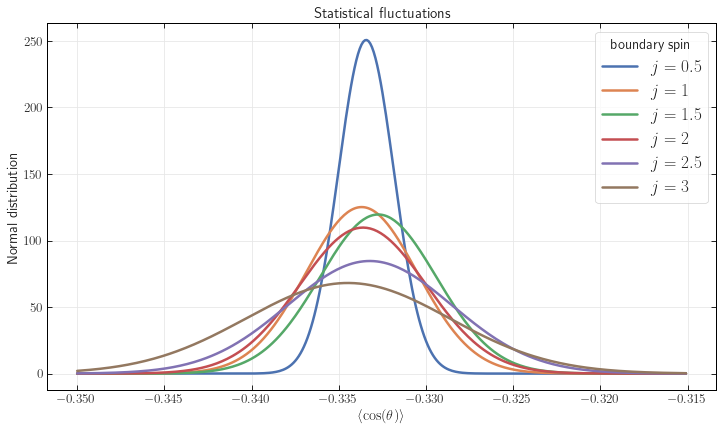

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#x-axis ranges from -5 and 5 with .001 steps
x = np.arange(-0.35, -0.315, 0.0001)

plt.figure(figsize=(12, 6.75))

#define multiple normal distributions
plt.plot(x,
         norm.pdf(x, -0.3334329648852039, 0.0015908416551159619),
         label='$j = 0.5$',
         linewidth=2.5)
plt.plot(x,
         norm.pdf(x, -0.3336911744117442, 0.0031875522725521945),
         label='$j = 1$',
         linewidth=2.5)
plt.plot(x,
         norm.pdf(x, -0.3327424146463688, 0.0033364313284318992),
         label='$j = 1.5$',
         linewidth=2.5)
plt.plot(x,
         norm.pdf(x, -0.33361569067079594, 0.0036353093158777283),
         label='$j = 2$',
         linewidth=2.5)
plt.plot(x,
         norm.pdf(x, -0.3332254129684163, 0.004714441869128369),
         label='$j = 2.5$',
         linewidth=2.5)
plt.plot(x,
         norm.pdf(x, -0.33448275454976717, 0.005858200089709406),
         label='$j = 3$',
         linewidth=2.5)

#add legend to plot
plt.legend(title='boundary spin',
           loc='upper right',
           fontsize='large',
           fancybox=True)

#add axes labels and a title
plt.ylabel('Normal distribution')
plt.xlabel(r"$\langle \cos (\theta) \rangle$")
plt.title('Statistical fluctuations', fontsize=15)

plt.show()

## Loglog plot (with fit) of hash tables size

We want to understand how fast the size of 21j Wigner symbols hash tables increases as a function of boundary spin j

In [25]:
size_hash_tables_in_MB = [
    12.8e-03, 409.5e-03, 6.55, 52.42, 209.71, 838.86, 3.35e+03, 6.71e+03
]
corresponding_spin = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

# fit log(size) = m*log(j) + c
m, c = np.polyfit(np.log(corresponding_spin),
                  np.log(size_hash_tables_in_MB),
                  1,
                  w=np.sqrt(size_hash_tables_in_MB))
size_fit = np.exp(m * np.log(corresponding_spin) + c)

df = pd.DataFrame({
    "spin": corresponding_spin,
    "table_size": size_hash_tables_in_MB,
    "fitted_data": size_fit
})


In [26]:
df

,spin,table_size,fitted_data
0,0.5,0.0128,0.004545
1,1.0,0.4095,0.526787
2,1.5,6.5500,8.492613
3,2.0,52.4200,61.053381
4,2.5,209.7100,281.963782
5,3.0,838.8600,984.273892
6,3.5,3350.0000,2832.373455
7,4.0,6710.0000,7075.943061


In [27]:
from matplotlib.ticker import ScalarFormatter

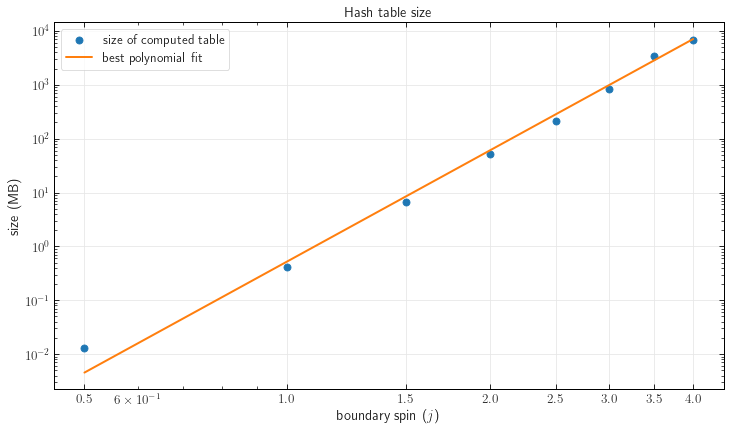

In [28]:
ax = df.plot(x='spin',
             y='table_size',
             s=50,
             xticks=corresponding_spin,
             kind='scatter',
             grid='false',
             color='tab:blue',
             label='size of computed table',
             logy=True,
             logx=True,
             figsize=(12, 6.75))
df.plot(x='spin',
        y='fitted_data',
        ax=ax,
        kind='line',
        color='tab:orange',
        label='best polynomial fit')
plt.ylabel("size (MB)")
plt.xlabel("boundary spin ($j$)")
plt.title('Hash table size')
ax.xaxis.set_major_formatter(ScalarFormatter())

plt.show()

We conclude that the size of the 21j Wigner symbols roughly increases as: 

$$ \text{Size(j)} \approx j^{6.86} - 0.64$$